Working on Task 6, Batch Optimizations and speed tests

In [ ]:
%%capture --no-stderr
%pip install --quiet -U ipykernel numpy matplotlib scikit-image 

In [1]:
import os
import time
import numpy as np
import concurrent.futures
import tifffile as tiff
from skimage.feature import ORB, match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, warp
from skimage.io import imsave
from scipy.ndimage import median_filter, gaussian_filter
import matplotlib.pyplot as plt
import boto3
import tifffile as tiff
import numpy as np
from io import BytesIO




# -------------------------------
# Radiometric & Geometric Correction (Tasks 1 & 2)
# -------------------------------

def read_tiff_from_s3(bucket_name, key):
    # Initialize S3 client
    s3_client = boto3.client('s3')
    
    # Get the object from S3
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    
    # Read the data using tifffile from the response body
    image_data = response['Body'].read()
    
    # Create a file-like object
    file_obj = BytesIO(image_data)
    
    # Read the TIFF using tifffile
    image = tiff.imread(file_obj).astype(np.float32)
    
    return image



def dark_object_subtraction(band, low_percentile=1):
    """
    Compute a robust dark object value by averaging all pixels below the given low percentile.
    
    Parameters:
      band (np.ndarray): Single band reflectance array.
      low_percentile (float): Percentile (0-100) used to threshold dark pixels (default is 1).
      
    Returns:
      float: Robust dark object value for the band.
    """
    # Determine the threshold at the low_percentile (e.g., 1st percentile)
    threshold = np.percentile(band, low_percentile)
    # Select pixels that are below or equal to this threshold
    dark_pixels = band[band <= threshold]
    # Compute and return the mean of these dark pixels
    return np.mean(dark_pixels) if dark_pixels.size > 0 else 0.0

def rigorous_radiometric_correction(image_path, gain, offset, sunelev, edist, Esun, 
                                               blackadjust=0.01, low_percentile=1):
    """
    Perform rigorous radiometric correction for a multispectral image using a robust dark object subtraction.
    
    Parameters:
      image_path (str): Path to the multispectral image.
      gain (array-like): Sensor gain for each band.
      offset (array-like): Sensor offset for each band.
      sunelev (float): Sun elevation in degrees.
      edist (float): Earth–Sun distance (in appropriate units).
      Esun (array-like): Exo-atmospheric solar irradiance for each band.
      blackadjust (float): Adjustment factor for dark object subtraction.
      low_percentile (float): Percentile (0-100) to estimate the dark object using a trimmed mean.
      
    Returns:
      np.ndarray: Corrected reflectance image in shape (bands, H, W) with values in [0,1].
    """
    # Read the TIFF using tifffile
        # Example usage
    bucket_name = 'qijaniproductsbucket'
    key = 'https://qijaniproductsbucket.s3.eu-north-1.amazonaws.com/20180627_seq_50m_NC.tif'
    image = read_tiff_from_s3(bucket_name, key)
    # image = tiff.imread(image_path).astype(np.float32)


    # The array is (H, W, bands) and we need (bands, H, W), transpose it.
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))
    
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    n_bands, h, w = image.shape
    radiance = np.empty_like(image)
    
    # Convert DN to radiance for each band using provided gain and offset.
    for i in range(n_bands):
        radiance[i] = gain[i] * image[i] + offset[i]
    
    # Compute sun zenith angle and its cosine.
    sun_zenith = 90 - sunelev
    cos_sun_zenith = np.cos(np.deg2rad(sun_zenith))
    
    # Ensure Esun is an array.
    Esun = np.array(Esun)
    
    # Apply the standard TOA reflectance formula:
    # reflectance = (pi * radiance * edist^2) / (Esun * cos(sun_zenith))
    reflectance = (np.pi * radiance * (edist**2)) / (Esun[:, None, None] * cos_sun_zenith)
    
    # Use the robust dark object method: for each band, compute the mean of the lowest low_percentile values.
    dark_obj = np.empty(n_bands, dtype=np.float32)
    for i in range(n_bands):
        dark_obj[i] = dark_object_subtraction(reflectance[i], low_percentile=low_percentile)
    
    # Apply an adjustment factor to the estimated dark object values.
    dark_obj_adj = dark_obj * (1 - blackadjust)
    
    # Subtract the dark object value from each band and clip the results to [0, 1].
    corrected = np.empty_like(reflectance)
    for i in range(n_bands):
        corrected[i] = np.clip(reflectance[i] - dark_obj_adj[i], 0, 1)
    
    return corrected

def compute_homography_sk(ref_img, tgt_img, detector_type='ORB'):
    """
    Computes the projective transform (homography) between two images using ORB features.
    
    Parameters:
      ref_img (np.ndarray): Reference image (H, W, channels).
      tgt_img (np.ndarray): Target image (H, W, channels).
      detector_type (str): Currently supports 'ORB'.
      
    Returns:
      ProjectiveTransform: Estimated projective transform.
    """
    # Convert to grayscale by averaging over bands
    ref_gray = np.mean(ref_img, axis=2) if ref_img.ndim == 3 else ref_img
    tgt_gray = np.mean(tgt_img, axis=2) if tgt_img.ndim == 3 else tgt_img

    orb = ORB(n_keypoints=500)
    orb.detect_and_extract(ref_gray)
    keypoints1, descriptors1 = orb.keypoints, orb.descriptors

    orb.detect_and_extract(tgt_gray)
    keypoints2, descriptors2 = orb.keypoints, orb.descriptors

    matches = match_descriptors(descriptors1, descriptors2, cross_check=True)
    if len(matches) < 4:
        raise RuntimeError("Not enough matches to compute homography.")
    
    src = keypoints1[matches[:, 0]]
    dst = keypoints2[matches[:, 1]]
    
    model_robust, inliers = ransac((src, dst), ProjectiveTransform, min_samples=4,
                                   residual_threshold=2, max_trials=1000)
    return model_robust

def warp_image_sk(image, transform, output_shape):
    """
    Warps the image using the given projective transform.
    
    Parameters:
      image (np.ndarray): Image (H, W, channels).
      transform (ProjectiveTransform): Estimated transform.
      output_shape (tuple): Desired output shape.
      
    Returns:
      np.ndarray: Warped (aligned) image.
    """
    return warp(image, inverse_map=transform.inverse, output_shape=output_shape)

def validate_alignment(ref_img, aligned_img):
    """
    Computes the RMSE between the reference and aligned images.
    
    Parameters:
      ref_img (np.ndarray): Reference image (H, W, channels).
      aligned_img (np.ndarray): Aligned image (H, W, channels).
      
    Returns:
      float: RMSE value.
    """
    diff = (ref_img - aligned_img) ** 2
    return np.sqrt(np.mean(diff))

def geometric_correction_pipeline(reference_image_path, target_image_path, radiometric_params, detector_type='ORB', visualize=False):
    """
    Executes the radiometric correction followed by geometric correction.
    
    Parameters:
      reference_image_path (str): Path to the reference image.
      target_image_path (str): Path to the target image.
      radiometric_params (dict): Radiometric parameters.
      detector_type (str): Feature detector type.
      visualize (bool): If True, display images.
      
    Returns:
      tuple: (Estimated transform, aligned image (H, W, channels), alignment RMSE)
    """
    # Apply radiometric correction to both images (output shape: (bands, H, W))
    ref_corr = rigorous_radiometric_correction(reference_image_path, **radiometric_params)
    tgt_corr = rigorous_radiometric_correction(target_image_path, **radiometric_params)
    
    # Transpose to (H, W, bands) for geometric processing
    ref_img = np.transpose(ref_corr, (1, 2, 0))
    tgt_img = np.transpose(tgt_corr, (1, 2, 0))
    
    # Compute the transform
    transform = compute_homography_sk(ref_img, tgt_img, detector_type)
    aligned_img = warp_image_sk(tgt_img, transform, ref_img.shape)
    rmse = validate_alignment(ref_img, aligned_img)
    
    if visualize:
        def prepare_display(img):
            # Use only the first 3 bands for RGB visualization if available.
            return img[..., :3] if img.shape[2] >= 3 else img
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(prepare_display(ref_img))
        plt.title("Reference (Radiometrically Corrected)")
        plt.subplot(1, 3, 2)
        plt.imshow(prepare_display(tgt_img))
        plt.title("Target (Radiometrically Corrected)")
        plt.subplot(1, 3, 3)
        plt.imshow(prepare_display(aligned_img))
        plt.title("Aligned Image")
        plt.show()
    
    return transform, aligned_img, rmse

# -------------------------------
# Noise Reduction (Task 3)
# -------------------------------
def noise_reduction_filter(image, method='median', kernel_size=3, sigma=1.0):
    """
    Apply noise reduction to a multispectral image.
    
    Parameters:
      image (np.ndarray): Input image (H, W, bands) with values in [0, 1].
      method (str): 'median' or 'gaussian'.
      kernel_size (int): Kernel size (must be odd).
      sigma (float): Standard deviation for Gaussian (ignored for median).
      
    Returns:
      np.ndarray: Filtered image.
    """
    filtered = np.empty_like(image)
    for band in range(image.shape[2]):
        if method == 'median':
            filtered[..., band] = median_filter(image[..., band], size=kernel_size)
        elif method == 'gaussian':
            truncate_val = ((kernel_size - 1) / 2) / sigma
            filtered[..., band] = gaussian_filter(image[..., band], sigma=sigma, truncate=truncate_val)
        else:
            raise ValueError("Method must be either 'median' or 'gaussian'.")
    return filtered

# Task 6: New noise reduction implementation using parallel processing for each band.
def noise_reduction_filter_parallel(image, method='median', kernel_size=3, sigma=1.0):
    """
    Task 6: Parallel noise reduction filter using ThreadPoolExecutor for each band.
    
    Parameters:
      image (np.ndarray): Input image (H, W, bands) with values in [0, 1].
      method (str): 'median' or 'gaussian'.
      kernel_size (int): Kernel size.
      sigma (float): Sigma for Gaussian.
      
    Returns:
      np.ndarray: Filtered image.
    """
    filtered = np.empty_like(image)
    def process_band(band):
        if method == 'median':
            return median_filter(image[..., band], size=kernel_size)
        elif method == 'gaussian':
            truncate_val = ((kernel_size - 1) / 2) / sigma
            return gaussian_filter(image[..., band], sigma=sigma, truncate=truncate_val)
        else:
            raise ValueError("Method must be either 'median' or 'gaussian'.")
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_band, range(image.shape[2])))
    for i, res in enumerate(results):
        filtered[..., i] = res
    return filtered


# -------------------------------
# NDVI Analysis (Task 5)
# -------------------------------
def compute_ndvi(image, red_band_index, nir_band_index):
    """
    Compute the Normalized Difference Vegetation Index (NDVI).
    
    NDVI = (NIR - Red) / (NIR + Red)
    
    Parameters:
      image (np.ndarray): Input image (H, W, bands), assumed in [0,1].
      nir_band_index (int): Index for NIR.
      red_band_index (int): Index for Red.
      
    Returns:
      np.ndarray: NDVI image.
    """
    nir = image[..., nir_band_index].astype(np.float32)
    red = image[..., red_band_index].astype(np.float32)
    return (nir - red) / (nir + red + 1e-10)

def validate_ndvi_improvement(original_image, filtered_image, nir_band_index, red_band_index):
    """
    Validate noise reduction effect by computing the RMSE between NDVI images.
    
    Parameters:
      original_image (np.ndarray): Original image (H, W, bands).
      filtered_image (np.ndarray): Noise-reduced image (H, W, bands).
      nir_band_index (int): Index for NIR.
      red_band_index (int): Index for Red.
      
    Returns:
      float: NDVI RMSE.
    """
    ndvi_orig = compute_ndvi(original_image, nir_band_index, red_band_index)
    ndvi_filt = compute_ndvi(filtered_image, nir_band_index, red_band_index)
    return np.sqrt(np.mean((ndvi_orig - ndvi_filt) ** 2))

# ----------------------------------------------
# Unified Pipeline: Combine Tasks 1, 2, 3 and 5
# ----------------------------------------------
def full_image_processing_pipeline(ref_image_path, target_image_path, radiometric_params, detector_type,
                                   noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
                                   visualize=False, use_parallel_noise_reduction=False):
    """
    Unified pipeline that executes:
      1. Radiometric and geometric correction.
      2. Noise reduction.
      3. NDVI computation and validation.
    
    Parameters:
      ref_image_path (str): Path to the reference image.
      target_image_path (str): Path to the target image.
      radiometric_params (dict): Radiometric parameters.
      detector_type (str): Feature detector type (e.g., 'ORB').
      noise_method (str): 'median' or 'gaussian'.
      noise_kernel_size (int): Kernel size for noise filtering.
      sigma (float): Sigma for Gaussian filtering.
      nir_band_index (int): Index for NIR band.
      red_band_index (int): Index for Red band.
      visualize (bool): If True, display intermediate results.
      use_parallel_noise_reduction (bool): If True, use the parallel noise reduction filter.
    
    Returns:
      tuple: (transform, aligned image, noise-reduced image, geometric RMSE, NDVI RMSE)
    """
    # Step 1: Radiometric and geometric correction.
    transform, aligned_img, geo_rmse = geometric_correction_pipeline(ref_image_path, target_image_path,
                                                                       radiometric_params, detector_type, visualize)
    
    # Step 2: Apply noise reduction to the aligned image.
    if use_parallel_noise_reduction:
        # Task 6: Using the parallel noise reduction filter.
        noise_reduced_img = noise_reduction_filter_parallel(aligned_img, method=noise_method,
                                                            kernel_size=noise_kernel_size, sigma=sigma)
    else:
        noise_reduced_img = noise_reduction_filter(aligned_img, method=noise_method,
                                                   kernel_size=noise_kernel_size, sigma=sigma)
    
    # Step 3: Compute NDVI before and after noise reduction.
    ndvi_aligned = compute_ndvi(aligned_img, nir_band_index, red_band_index)
    ndvi_noise_reduced = compute_ndvi(noise_reduced_img, nir_band_index, red_band_index)
    ndvi_rmse = np.sqrt(np.mean((ndvi_aligned - ndvi_noise_reduced) ** 2))
    
    if visualize:
        # Display NDVI images for comparison.
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(ndvi_aligned, cmap='RdYlGn')
        plt.title("Aligned Image NDVI")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(ndvi_noise_reduced, cmap='RdYlGn')
        plt.title("Noise-Reduced NDVI")
        plt.colorbar()
        plt.show()
    
    return transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse

# -------------------------------
# Task 6: Batch Processing & Benchmarking Functions
# -------------------------------

def run_pipeline_with_benchmark(ref_image_path, target_image_path, radiometric_params, detector_type,
                                noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
                                visualize=False, use_parallel_noise_reduction=False):
    """
    Task 6: Run the full processing pipeline while benchmarking its execution time.
    This function integrates the timing measurement with the pipeline execution,
    preventing the pipeline from running twice.

    Returns:
      tuple: (transform, aligned image, noise-reduced image, geometric RMSE, NDVI RMSE, elapsed time)
    """
    start = time.time()
    results = full_image_processing_pipeline(
        ref_image_path, target_image_path, radiometric_params, detector_type,
        noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
        visualize, use_parallel_noise_reduction
    )
    end = time.time()
    elapsed_time = end - start
    print("Task 6: Whole pipeline processing took {:.4f} seconds for image pair: {} and {}"
          .format(elapsed_time, ref_image_path, target_image_path))
    # Unpack the pipeline results and return with elapsed time.
    transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse = results
    return transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse, elapsed_time


def batch_process_ndvi(pairs, radiometric_params, detector_type, noise_method, noise_kernel_size, sigma,
                       nir_band_index, red_band_index, use_parallel_noise_reduction=False):
    """
    Task 6: Process NDVI for multiple image pairs concurrently.
    
    Parameters:
      pairs (list of tuples): Each tuple is (ref_image_path, target_image_path)
      radiometric_params, detector_type, noise_method, etc.: As in the unified pipeline.
      use_parallel_noise_reduction (bool): Whether to use the parallel noise reduction filter.
    
    Returns:
      list: A list of results from full_image_processing_pipeline for each pair.
    """
    results = []
    start_time = time.time()
    # Using ProcessPoolExecutor for batch processing across multiple pairs.
    with concurrent.futures.ProcessPoolExecutor() as executor:
         futures = []
         for ref_image_path, target_image_path in pairs:
             futures.append(executor.submit(full_image_processing_pipeline, 
                            ref_image_path, target_image_path, radiometric_params, detector_type, 
                            noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
                            False, use_parallel_noise_reduction))
         for future in concurrent.futures.as_completed(futures):
             results.append(future.result())
    end_time = time.time()
    # Task 6: Print benchmark report.
    print("Task 6: Batch NDVI Processing Benchmark Report")
    print("Processed {} image pairs in {:.2f} seconds".format(len(pairs), end_time - start_time))
    return results

# -------------------------------
# Main Block for Testing the Integrated Pipeline and Benchmarking
# -------------------------------
if __name__ == "__main__":
    # Radiometric parameters as used in Tasks 1 & 2.
  radiometric_params = {
      # Typical gain values for Sequoia are on the order of 0.01–0.02;
      # here we assume a nominal gain of 0.012 for all five bands.
      'gain': [0.012, 0.012, 0.012, 0.012, 0.012],
      # Offsets are generally very low for the Sequoia; we assume zero offset.
      'offset': [0, 0, 0, 0, 0],
      # Sun elevation is flight dependent; 60° is a good example.
      'sunelev': 60.0,
      # Earth–Sun distance is typically normalized to 1.0 for these calculations.
      'edist': 1.0,
      # Exo-atmospheric solar irradiance values (Esun) are often reported as:
      # Blue: ~1913, Green: ~1822, Red: ~1557, Red Edge: ~1317, NIR: ~1074 (W/m²/μm)
      'Esun': [1913, 1822, 1557, 1317, 1074],
      # A small black adjustment factor helps account for sensor noise.
      'blackadjust': 0.01,
      # For the robust dark object subtraction, use the 1st percentile (i.e. low_percentile=1)
      'low_percentile': 1
} 

  # File paths (adjust these paths as needed).
  ref_image_path = "testfiles/target_images/20180627_seq_50m_NC.tif"
  target_image_path = "testfiles/target_images/20180627_seq_50m_NC copy.tif"
  
  # For DJI Mavic 3M multispectral images, the typical band order is:
  # Blue: 0, Green: 1, Red: 2, Red Edge: 3, NIR: 4.
  # For NDVI, we use red and NIR. Here we set:
  nir_band_index = 4
  red_band_index = 2  # Note: Adjust if data order differs.
  
  # Noise reduction parameters.
  noise_method = 'median'  # Can also be 'gaussian'
  noise_kernel_size = 3
  sigma = 1.0  # Only used for Gaussian filtering
    
  # Run the pipeline with integrated benchmarking.
  transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse, elapsed_time = run_pipeline_with_benchmark(
      ref_image_path, target_image_path, radiometric_params, detector_type='ORB',
      noise_method=noise_method, noise_kernel_size=noise_kernel_size, sigma=sigma,
      nir_band_index=nir_band_index, red_band_index=red_band_index, visualize=True,
      use_parallel_noise_reduction=False  # Set to True to use the parallel noise reduction filter.
  )
    
  # Display performance metrics.
  print("Geometric Correction RMSE:", geo_rmse)
  print("NDVI RMSE after noise reduction: {:.6f}".format(float(ndvi_rmse)))
  


NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

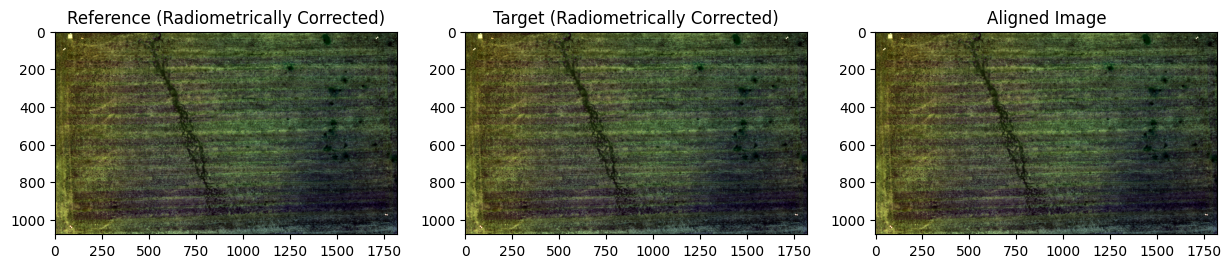

Estimated Carbon Credits: 200.91 tCO₂e


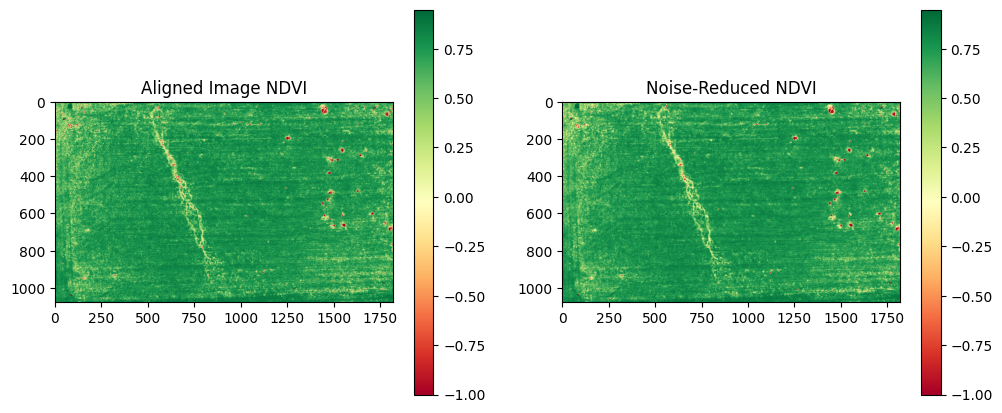

Task 6: Whole pipeline processing took 3.9246 seconds for image pair: testfiles/target_images/20180627_seq_50m_NC.tif and testfiles/target_images/20180627_seq_50m_NC copy.tif
Geometric Correction RMSE: 1.0294309795505686e-14
NDVI RMSE after noise reduction: 0.046784


In [17]:

def estimate_biomass(ndvi, a=2.5, b=1.2):
    """
    Estimate Above-Ground Biomass (AGB) using an empirical NDVI-to-biomass model.
    
    Parameters:
      ndvi (np.ndarray): NDVI image.
      a (float): Biomass coefficient (default: 5).
      b (float): NDVI exponent factor (default: 1.2).
      
    Returns:
      np.ndarray: Estimated biomass per pixel.
    """
    return a * np.exp(b * ndvi)  # Biomass in kg/m²

def calculate_carbon_storage(biomass, carbon_fraction=0.47):
    """
    Convert biomass to stored carbon using IPCC carbon fraction.
    
    Parameters:
      biomass (np.ndarray): Biomass per pixel (kg/m²).
      carbon_fraction (float): Fraction of biomass that is carbon (default: 0.47).
      
    Returns:
      np.ndarray: Carbon stored per pixel (kg/m²).
    """
    return biomass * carbon_fraction

def convert_carbon_to_co2(carbon_storage):
    """
    Convert stored carbon to CO₂ equivalent.
    
    Parameters:
      carbon_storage (np.ndarray): Carbon stored per pixel (kg/m²).
      
    Returns:
      np.ndarray: CO₂ sequestered per pixel (kg/m²).
    """
    return carbon_storage * (44 / 12)  # CO₂ equivalent (kg/m²)

def calculate_carbon_credits(co2_sequestration, pixel_area_m2):
    """
    Calculate total carbon credits from CO₂ sequestration.
    
    Parameters:
      co2_sequestration (np.ndarray): CO₂ stored per pixel (kg/m²).
      pixel_area_m2 (float): Area of each pixel in square meters.
      
    Returns:
      float: Total carbon credits (1 credit = 1 metric ton CO₂).
    """
    total_co2_kg = np.sum(co2_sequestration * pixel_area_m2)  # Convert per-pixel to total CO₂ in kg
    total_co2_tonnes = total_co2_kg / 1000  # Convert kg to metric tonnes
    return total_co2_tonnes  # Carbon credits (1 credit = 1 tCO₂e)

# ==== AUTOMATION PIPELINE ====
def process_ndvi_for_carbon_credits(ndvi_aligned, pixel_area_m2):
    """
    Full pipeline to process NDVI into carbon credits.
    
    Parameters:
      ndvi_aligned (np.ndarray): NDVI image.
      pixel_area_m2 (float): Area of each pixel in square meters.
      
    Returns:
      float: Total carbon credits for the farm.
    """
    biomass = estimate_biomass(ndvi_aligned)  # Step 1: Estimate biomass
    carbon_storage = calculate_carbon_storage(biomass)  # Step 2: Convert to carbon storage
    co2_sequestration = convert_carbon_to_co2(carbon_storage)  # Step 3: Convert to CO₂ equivalent
    carbon_credits = calculate_carbon_credits(co2_sequestration, pixel_area_m2)  # Step 4: Calculate credits
    
    return carbon_credits

# Example Usage (Assumes ndvi_aligned is already computed)

# ----------------------------------------------
# Unified Pipeline:
# ----------------------------------------------
def full_image_processing_pipeline2(ref_image_path, target_image_path, radiometric_params, detector_type,
                                   noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
                                   visualize=False, use_parallel_noise_reduction=False):
    """
    Unified pipeline that executes:
      1. Radiometric and geometric correction.
      2. Noise reduction.
      3. NDVI computation and validation.
    
    Parameters:
      ref_image_path (str): Path to the reference image.
      target_image_path (str): Path to the target image.
      radiometric_params (dict): Radiometric parameters.
      detector_type (str): Feature detector type (e.g., 'ORB').
      noise_method (str): 'median' or 'gaussian'.
      noise_kernel_size (int): Kernel size for noise filtering.
      sigma (float): Sigma for Gaussian filtering.
      nir_band_index (int): Index for NIR band.
      red_band_index (int): Index for Red band.
      visualize (bool): If True, display intermediate results.
      use_parallel_noise_reduction (bool): If True, use the parallel noise reduction filter.
    
    Returns:
      tuple: (transform, aligned image, noise-reduced image, geometric RMSE, NDVI RMSE)
    """
    # Step 1: Radiometric and geometric correction.
    transform, aligned_img, geo_rmse = geometric_correction_pipeline(ref_image_path, target_image_path,
                                                                       radiometric_params, detector_type, visualize)
    
    # Step 2: Apply noise reduction to the aligned image.
    if use_parallel_noise_reduction:
        # Task 6: Using the parallel noise reduction filter.
        noise_reduced_img = noise_reduction_filter_parallel(aligned_img, method=noise_method,
                                                            kernel_size=noise_kernel_size, sigma=sigma)
    else:
        noise_reduced_img = noise_reduction_filter(aligned_img, method=noise_method,
                                                   kernel_size=noise_kernel_size, sigma=sigma)
    
    # Step 3: Compute NDVI before and after noise reduction.
    ndvi_aligned = compute_ndvi(aligned_img, nir_band_index, red_band_index)
    ndvi_noise_reduced = compute_ndvi(noise_reduced_img, nir_band_index, red_band_index)
    ndvi_rmse = np.sqrt(np.mean((ndvi_aligned - ndvi_noise_reduced) ** 2))
    carbon_credits = process_ndvi_for_carbon_credits(ndvi_aligned, pixel_area_m2=0.01)  # Adjust pixel size as needed
    print(f"Estimated Carbon Credits: {carbon_credits:.2f} tCO₂e")
    
    if visualize:
        # Display NDVI images for comparison.
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(ndvi_aligned, cmap='RdYlGn')
        plt.title("Aligned Image NDVI")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(ndvi_noise_reduced, cmap='RdYlGn')
        plt.title("Noise-Reduced NDVI")
        plt.colorbar()
        plt.show()
    
    return transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse
  
  

def run_pipeline_with_benchmark2(ref_image_path, target_image_path, radiometric_params, detector_type,
                                noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
                                visualize=False, use_parallel_noise_reduction=False):
    """
    Task 6: Run the full processing pipeline while benchmarking its execution time.
    This function integrates the timing measurement with the pipeline execution,
    preventing the pipeline from running twice.

    Returns:
      tuple: (transform, aligned image, noise-reduced image, geometric RMSE, NDVI RMSE, elapsed time)
    """
    start = time.time()
    results = full_image_processing_pipeline2(
        ref_image_path, target_image_path, radiometric_params, detector_type,
        noise_method, noise_kernel_size, sigma, nir_band_index, red_band_index,
        visualize, use_parallel_noise_reduction
    )
    end = time.time()
    elapsed_time = end - start
    print("Task 6: Whole pipeline processing took {:.4f} seconds for image pair: {} and {}"
          .format(elapsed_time, ref_image_path, target_image_path))
    # Unpack the pipeline results and return with elapsed time.
    transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse = results
    return transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse, elapsed_time
  
  
  
# -------------------------------
# Main Block for Testing the Integrated Pipeline and Benchmarking
# -------------------------------
if __name__ == "__main__":
    # Radiometric parameters as used in Tasks 1 & 2.
  radiometric_params = {
      # Typical gain values for Sequoia are on the order of 0.01–0.02;
      # here we assume a nominal gain of 0.012 for all five bands.
      'gain': [0.012, 0.012, 0.012, 0.012, 0.012],
      # Offsets are generally very low for the Sequoia; we assume zero offset.
      'offset': [0, 0, 0, 0, 0],
      # Sun elevation is flight dependent; 60° is a good example.
      'sunelev': 60.0,
      # Earth–Sun distance is typically normalized to 1.0 for these calculations.
      'edist': 1.0,
      # Exo-atmospheric solar irradiance values (Esun) are often reported as:
      # Blue: ~1913, Green: ~1822, Red: ~1557, Red Edge: ~1317, NIR: ~1074 (W/m²/μm)
      'Esun': [1913, 1822, 1557, 1317, 1074],
      # A small black adjustment factor helps account for sensor noise.
      'blackadjust': 0.01,
      # For the robust dark object subtraction, use the 1st percentile (i.e. low_percentile=1)
      'low_percentile': 1
} 

  # File paths (adjust these paths as needed).
  ref_image_path = "testfiles/target_images/20180627_seq_50m_NC.tif"
  target_image_path = "testfiles/target_images/20180627_seq_50m_NC copy.tif"
  
  # For DJI Mavic 3M multispectral images, the typical band order is:
  # Blue: 0, Green: 1, Red: 2, Red Edge: 3, NIR: 4.
  # For NDVI, we use red and NIR. Here we set:
  nir_band_index = 4
  red_band_index = 2  # Note: Adjust if data order differs.
  
  # Noise reduction parameters.
  noise_method = 'median'  # Can also be 'gaussian'
  noise_kernel_size = 3
  sigma = 1.0  # Only used for Gaussian filtering
    
  # Run the pipeline with integrated benchmarking.
  transform, aligned_img, noise_reduced_img, geo_rmse, ndvi_rmse, elapsed_time = run_pipeline_with_benchmark2(
      ref_image_path, target_image_path, radiometric_params, detector_type='ORB',
      noise_method=noise_method, noise_kernel_size=noise_kernel_size, sigma=sigma,
      nir_band_index=nir_band_index, red_band_index=red_band_index, visualize=True,
      use_parallel_noise_reduction=False  # Set to True to use the parallel noise reduction filter.
  )
    
  # Display performance metrics.
  print("Geometric Correction RMSE:", geo_rmse)
  print("NDVI RMSE after noise reduction: {:.6f}".format(float(ndvi_rmse)))
  

